In [1]:
import jax, jax.numpy as jnp, jax.random as jr
jax.config.update("jax_enable_x64", False)
import numpy as np, sys, os, time
import matplotlib.pyplot as plt
from functools import partial
import tqdm.auto as tqdm
na = jnp.newaxis

sys.path.insert(0, '../../22_3_1_DLC_MOSEQ/keypointMoSeq/')
from keypoint_moseq.util import *
from keypoint_moseq.gibbs import *
from keypoint_moseq.initialize import *
from keypoint_moseq.kalman import kalman_sample, kalman_filter

In [2]:
latent_dim = 6           # dimension of latent trajectories
num_states = 50         # max number of states
nlags = 3                # number of lags for AR dynamics

keypoint_dim = 2   # embedding dimension of keypoints
num_keypoints = 9  # number of keypoints

trans_hypparams = {
    'gamma': 1e3, 
    'alpha': 100, 
    'kappa': 5e7,
    'num_states':num_states}

ar_hypparams = {
    'nu_0': latent_dim+2,
    'S_0': 10*jnp.eye(latent_dim),
    'M_0': jnp.pad(jnp.eye(latent_dim),((0,0),((nlags-1)*latent_dim,1))),
    'K_0': 0.01*jnp.eye(latent_dim*nlags+1),
    'num_states':num_states,
    'nlags':nlags}

obs_hypparams = {
    'sigmasq_0': 1,
    'sigmasq_C': .1,
    's_0': 1}

translation_hypparams = {
    'sigmasq_loc': 1
}

hypparams = {
    'latent_dim' : 6,
    'trans_hypparams' : trans_hypparams,
    'ar_hypparams' : ar_hypparams,
    'obs_hypparams' : obs_hypparams,
    'translation_hypparams' : translation_hypparams,
    'inlier_variance' : 10,
    'outlier_variance' : 1e6,
    'keypoint_dx_variance' : 5,
    'keypoint_pos_variance' : 10, # deviation of keypoints from expected positions
    'anterior_keypoints' : [6,7,8],
    'posterior_keypoints' : [1,2,3]
}

In [3]:
def npad(X, n, axis):
    return [(0,0) if i != axis else (0,n-X.shape[axis]) for i in range(len(X.shape))]

In [18]:
import os, joblib

cam_ix = 1
camera = 'bottom'
data_dir = '../../22_2_6_opto_attack_with_PFC_recordings_v2/'
segments = joblib.load('../../22_2_6_opto_attack_with_PFC_recordings_v2/segments.p')

Ys,As,Is,names = [],[],[],[]
for prefix,segs in tqdm.tqdm(segments.items()):
    Y = np.transpose(np.load(data_dir+prefix+'.bottom.Y.npy'), axes=(2,0,1,3))
    I = np.transpose(np.load(data_dir+prefix+'.bottom.I.npy'), axes=(2,3,0,1))
    A = np.transpose(np.load(data_dir+prefix+'.bottom.A.npy'), axes=(2,3,0,1))
    for i,(s,e) in enumerate(segs):
        names.append(prefix+'-seg{}'.format(i))
        Ys.append(Y[:,s:e])
        Is.append(I[:,:,s:e])
        As.append(A[:,:,s:e])
    if len(names)>10: break

max_length = np.max([Y.shape[1] for Y in Ys])
observations = jnp.array([np.pad(Y, npad(Y,max_length,1)) for Y in Ys])
identity = jnp.array([np.pad(I, npad(I,max_length,2)) for I in Is])
affinity = jnp.array([np.pad(A, npad(A,max_length,2)) for A in As])
outlier_prob = jnp.clip(jax.nn.sigmoid((.5-outlier_prob)*20),1e-6,0.8)
mask = jnp.array([np.pad(np.ones(Y.shape[1]), (0,max_length-Y.shape[1])) for Y in Ys])
        
# observations,mask,data_keys = merge_data(data_dict, batch_length=1000)
# observations,mask = jnp.array(observations[:10,...,na,:]),jnp.array(mask[:10])
# outlier_prob = jnp.ones_like(observations[...,0])*1e-2

  0%|          | 0/51 [00:00<?, ?it/s]

In [19]:

def sample_positions(key, obs, mask, outliers, hypparams):
    keys = jr.split(key, obs.shape[-2])
    m0,S0 = obs[:,0], jnp.eye(obs.shape[-1])
    As = jnp.tile(jnp.eye(obs.shape[-1]),(obs.shape[1],1,1))
    Bs = jnp.tile(jnp.zeros(obs.shape[-1]), (obs.shape[1],1))
    Qs = As*hypparams['keypoint_dx_variance']
    Qinvs = As/hypparams['keypoint_dx_variance']
    C,D = jnp.eye(obs.shape[-1]), jnp.zeros(obs.shape[-1])
    Rs = jnp.ones(obs.shape[-1])*(
        hypparams['outlier_variance']*outliers[...,na]
       +hypparams['inlier_variance']*(1-outliers[...,na]))
    resample_one = jax.vmap(kalman_sample, in_axes=(0,-2,na,-2,na,na,na,na,na,na,na,-2), out_axes=-2)
    resample_all = jax.vmap(resample_one,  in_axes=(na,0,0 ,0 ,na,na,na,na,na,na,na,0), out_axes=0)
    return resample_all(keys, obs, mask, m0, S0, As, Bs, Qs, Qinvs, C, D, Rs)[:,:-1]


def sample_outliers(key, obs, positions, outlier_prob, hypparams):
    outlier_lp = observations_log_prob(obs, positions, hypparams['outlier_variance'])
    inlier_lp = observations_log_prob(obs, positions, hypparams['inlier_variance'])
    prob = jnp.exp(outlier_lp - jnp.logaddexp(outlier_lp,inlier_lp)) * outlier_prob
    return jr.bernoulli(key, prob)
                      
def observations_log_prob(obs, positions, variance):
    sqdev = ((obs-positions)**2).sum(-1)
    norm = jnp.log(variance)/2*obs.shape[-1]
    return -sqdev/2/variance-norm
    
def eliminate_camera_axis(obs, outlier_prob):
    return obs[...,0,:],outlier_prob[...,0]
    
    
    

class KeypointSLDS:
    def __init__(self, hypparams, params=None):
        self.key = jr.PRNGKey(0)
        self.hypparams = hypparams
        if params is None: self.params = {}
        else: self.params = params
        self.states = {}
        self.positions = None
    
    def initialize(self, obs, outlier_prob, mask):
        obs,outlier_prob = eliminate_camera_axis(obs,outlier_prob)
        self.key, *keys = jr.split(self.key, 6)
        data = {'Y':obs, 'mask':mask}
    
        # initialize outliers
        self.outliers = jr.bernoulli(keys[0], outlier_prob)
        
        # initialize centroid/heading
        self.states['v'] = v = initial_location(
            **data, **self.states, outliers=self.outliers)

        self.states['h'] = h = initial_heading(
            **data, **self.states, **self.hypparams, outliers=self.outliers)
        
        # initialize latent states and obs params
        if not 'sigmasq' in self.params: 
            self.params['sigmasq'] = jnp.ones(data['Y'].shape[-2]) * \
                self.hypparams['obs_hypparams']['sigmasq_0']

        self.states['s'] = jnp.ones(obs.shape[:-1]) * \
            self.hypparams['obs_hypparams']['s_0']

        if not 'Cd' in self.params:
            self.states['x'],self.params['Cd'] = initial_latents(
                keys[1], latent_dim=self.hypparams['latent_dim'], 
                **data, **self.states, outliers=self.outliers)
        else: 
            Cd,Gamma = self.params['Cd'], center_embedding(data['Y'].shape[-2])
            ys = inverse_affine_transform(data['Y'],v,h).reshape(*data['Y'].shape[:-2],-1)
            self.states['x'] = (ys@jnp.kron(Gamma, jnp.eye(2)) - Cd[:,-1]) @ Cd[:,:-1]

        # initialize positions
        self.positions = sample_positions(keys[2], obs, mask, self.outliers, self.hypparams)

        # initialize AR params and stateseq
        if not 'pi' in self.params: self.params['betas'],self.params['pi'] = \
            initial_hdp_transitions(keys[3], **self.hypparams['trans_hypparams'])
        if not 'Ab' in self.params: self.params['Ab'],self.params['Q'] = \
            initial_ar_params(keys[4], **self.hypparams['ar_hypparams'])
        self.states['z'] = resample_stateseqs(keys[4], **data, **self.states, **self.params)

    
    def resample_states(self, data):
        self.key, *keys = jr.split(self.key, 5)
        
        self.states['z'] = resample_stateseqs(
            keys[0], **data, **self.states, **self.params)
        
        self.states['x'] = resample_latents(
            keys[1], **data, **self.states, **self.params)
        
        self.states['h'] = resample_heading(
            keys[2], **data, **self.states, **self.params)
        
        self.states['v'] = resample_location(
            key[3], **data, **self.states, **self.params, 
            **self.hypparams['translation_hypparams'])
        
        
    def resample_params(self, data):
        self.key, *keys = jr.split(self.key, 4)
        
        self.params['Ab'],self.params['Q'] = resample_ar_params(
            keys[0], **data, **self.states, **self.params, 
            **self.hypparams['ar_hypparams'])

        self.params['Cd'] = resample_obs_params(
            keys[1], **self.data, **self.states, **self.params, 
            **self.hypparams['obs_hypparams'])

        self.params['betas'],self.params['pi'] = resample_hdp_transitions(
            keys[2], **data, **self.states, **self.params, 
            **self.hypparams['trans_hypparams'])
        
        
    def step(self, obs, outlier_prob, mask, update_params=False):
        self.key, *keys = jr.split(self.key, 3)
        obs,outlier_prob = eliminate_camera_axis(obs,outlier_prob)
        
        self.outliers = sample_outliers(
            keys[0], obs, self.positions, outlier_prob, self.hypparams)
        
        self.positions = sample_positions(
            keys[1], obs, mask, self.outliers, self.hypparams)
        
        data = {'Y': self.positions, 'mask':mask}
        self.resample_states(data)
        if update_params: self.resample_params(data)


    def log_likelihood(self, obs, outlier_prob):
        obs,outlier_prob = eliminate_camera_axis(obs,outlier_prob)
        
        outlier_lp = observations_log_prob(
            obs, self.positions, self.hypparams['outlier_variance'])
        
        inlier_lp = observations_log_prob(
            obs, self.positions, self.hypparams['inlier_variance'])
        
        prior = jnp.stack([1-outlier_prob, outlier_prob])
        lp = jax.nn.logsumexp(jnp.stack([inlier_lp,outlier_lp]), b=prior, axis=0)
        return lp[...,na]

    


In [ ]:
cp keypoint_sort-gimabl-v2.ipynb

In [3]:
def convert_to_jax(params):
    params_out = {}
    for key,val in params.items():
        if isinstance(val, np.ndarray):
            val = jnp.array(val)
        params_out[key] = val
    return params_out


@jax.jit
def gaussian_log_prob(x, mu, sigma_inv):
    return (-((mu-x)[...,na,:]*sigma_inv*(mu-x)[...,:,na]).sum((-1,-2))/2
            +jnp.log(jnp.linalg.det(sigma_inv))/2)

class Gimbal:
    def __init__(self, params, hmc_options):
        self.seed = jr.PRNGKey(0)
        params = convert_to_jax(params)
        params = gimbal.mcmc.initialize_parameters(params)
        self.params = self.augment_params(params)
        self.hmc_options = hmc_options
        self.samples = None
        
    def augment_params(self, params):
        params['obs_inlier_precision'] = jnp.linalg.inv(params['obs_inlier_covariance'])
        params['obs_outlier_precision'] = jnp.linalg.inv(params['obs_outlier_covariance'])
        return params
        
    def initialize(self, obs, outlier_prob, mask):
        self.samples = []
        for i in range(obs.shape[0]):
            self.params['obs_outlier_probability'] = \
                jnp.swapaxes(outlier_prob[i], -2, -1)
            self.samples.append(gimbal.mcmc.initialize(
                self.seed, self.params, jnp.swapaxes(obs[i], -2, -3)))
                
    def step(self, obs, outlier_prob, mask, **kwargs):
        assert self.samples is not None, 'Must run `Gimbal.initialize first'
        self.seed = jr.split(self.seed)[0]
        for i in range(obs.shape[0]):
            self.params['obs_outlier_probability'] = \
                jnp.swapaxes(outlier_prob[i], -2, -1)
            self.samples[i] = gimbal.mcmc.step(
                self.seed, self.params, jnp.swapaxes(obs[i], -2, -3), 
                self.samples[i], **self.hmc_options)
    
    def log_likelihood(self, obs, outlier_prob):
        pred = jax.vmap(gimbal.mcmc.project, in_axes=(0,None), out_axes=-3)(
            self.params['camera_matrices'], self.samples['positions'])
        err = pred-self.reshape_obs(obs)
        inlier_lp = gaussian_log_prob(err, self.params['obs_inlier_location'], self.params['obs_inlier_precision'])
        outlier_lp = gaussian_log_prob(err, self.params['obs_outlier_location'], self.params['obs_outlier_precision'])
        outlier_prob = self.reshape_outlier_prob(outlier_prob)
        prior = jnp.stack([1-outlier_prob, outlier_prob])
        lp = jax.nn.logsumexp(jnp.stack([inlier_lp,outlier_lp]), b=prior, axis=0)
        return jnp.swapaxes(lp, -1, -2)


In [4]:
class KeypointSort:
    """Implements the keypoint sorting model described in [paper].
    Given keypoint observations for multiple animals, the goal
    is to infer the animal-identity for each keypoint.
    
    Inference is based on part-affinity-field scores for the keypoints
    and on a kinematics model for each animal. The kinematics model
    is modular: any model can be used as long as it can produce
    a log-likelihood score for each keypoint observation. 
    
    Parameters
    ----------
    kinematics_models : list of objects (one per animal)
        Objects to use for kinematics modeling. 
    
    observations: ndarray, shape (N,T,K,C,dim_obs)
        Location of instance i of keypoint k for time t and camera c
        
    outlier_probs: ndarray, shape (N,T,K,C)
        Outlier probabilities based on neural net confidence

    affinity : ndarray, shape (N,N,T,K,C)
        Log probability that two keypoints observations belong to same animal.
        affinity[i,j,t,k,c] = log P(instance i of keypoint k is from the same
        animal as instance j of keypoint parent(k) for time t and camera c)

    identity : ndarray, shape (N,N,T,K,C)
        Log probability that each keypoint observation belongs to a specific
        animal. identity[i,j,t,k,c] = log P(instance i of keypoint k belongs
        to animal j for time t and camera c)

    assignments: ndarray, shape (N,T,K,C)
        The current animal assignment for each keypoint observation.
        assignment[i,t,k,c] = assignment of instance i of keypoint k
        for time t and camera c.  
        
    parents : ndarray, shape (K,)
        The parent of each joint. parent[i] = [parent of node i]. The root 
        node should be its own parent.
        
    top_order : ndarray, shape (K,)
        Topological ordering of joints (parents followed by children).
   
    permutations : ndarray, shape (N!,N)
        All permutations of size N
        
    """
    def __init__(self, parents,
                 kinematics_models, 
                 observations,
                 outlier_probs,
                 affinity, 
                 identity):

        N,T,K,C, = observations.shape[:-1]
        self.parents = parents
        self.observations = observations
        self.outlier_probs = outlier_probs
        self.affinity = affinity
        self.identity = identity
        self.kinematics_models = kinematics_models
        
        # initialize params
        self.key = jax.random.PRNGKey(0)
        self.top_order = self.topological_sort(parents)
        self.permutations = self.all_permutations(N)
        self.clique_affinity = (affinity[self.permutations,:][:,self.permutations] 
                              * jnp.eye(N).reshape(1,N,1,N,1,1,1)).sum((1,3))
        
        self.clique_affinity_row_norm = self.normalize(self.clique_affinity, axis=1)
        self.clique_affinity_col_norm = self.normalize(self.clique_affinity, axis=0)
        
        
    def all_permutations(self,N):
        """Return all permutations of size n (one permutation per row)
        """
        import itertools
        return jnp.array(list(itertools.permutations(range(N))))

    def topological_sort(self, parents):
        """ Sort tree nodes such that parents precede children
        """
        parents = np.array(parents)
        to_go = np.ones(len(parents))>0
        topological_order = []
        while True:
            leaves = np.all([to_go,~np.in1d(np.arange(len(parents)),parents[to_go])],axis=0).nonzero()[0]
            if len(leaves)==0: break
            topological_order.append(leaves)
            to_go[leaves] = 0
        topological_order.append(to_go.nonzero()[0])
        return jnp.array(np.hstack(topological_order))[::-1]

    def initialize(self, eta=50):
        """Initialize assignments using maximum likelihood inference over 
        affinities, initial identity probabilities and keypoint proximity,
        then use these assignments to initialize the kinematics models.
        """
        self.assignments = self.initial_assignments(eta=eta)
        for model, obs, out_p in zip(self.kinematics_models,
                                     self.split(self.observations,self.assignments),
                                     self.split(self.outlier_probs,self.assignments)): 
            model.initialize(obs, out_p)
        
    def step(self):
        """Perform one Gibbs step. Each step consists of resampling params in 
        each kinematics model (using the current assignments), and then resampling
        assignments using log probabilities from the kinematics models. 
        """
        assign_lls = [jax.vmap(model.log_likelihood)(self.observations, self.outlier_probs) 
                      for model in self.kinematics_models]
        
        self.assignments = self.forward_backward_assignments(jnp.stack(assign_lls)+self.identity)
        for model, obs, out_p in zip(self.kinematics_models,
                                     self.split(self.observations,self.assignments),
                                     self.split(self.outlier_probs,self.assignments)): 
            model.step(obs, out_p)

    
    def split(self, X, assignments):
        """Use assignments to sort an array X of shape (N,T,K,C,...) such 
        that all keypoints for animal i are in slice [i,:,:,:,...]
        """
        assignments = assignments.reshape(list(assignments.shape)+[1]*(len(X.shape)-4))
        return jnp.take_along_axis(X,assignments,axis=0)
     
    def initial_assignments(self, eta=50):
        """To initialize assignments, first get maximum likelihood assignments
        for each frame separately using just affinities and identity probabilities,
        then use the continuity of keypoint locations to optionally permute
        the labels in each frame (eta = gaussian kernel variance for continuity).
        """
        N, T, K, C, permutations = *self.observations.shape[:-1], self.permutations
        
        # the following assignments are based on optimizing each frame separately
        assignments_init = self.viterbi_assignments(self.identity)
        
        # get permutation_lls[p,t,c] = log P (identity | permutation p (assignments_init[time t and camera c]))
        group_lls = self.split(jnp.moveaxis(self.identity,1,-1), assignments_init).sum(2)
        permutations_lls = (group_lls[self.permutations] * jnp.eye(N).reshape(1,N,1,1,N)).sum((1,4))
        
        # tmats[c,t,:,:] = permutation->permutation transitions probs, based on 
        # random walk model with variance eta for keypoint motion across frames
        obs_split = self.split(self.observations, assignments_init)
        permutation_transition_ll = ((obs_split[permutations] - obs_split[na])**2).sum((1,3,5)) / eta
        perm2perm = jnp.argmax((permutations[:,permutations][:,:,na,:]==permutations[na,na:,:]).sum(-1),-1) 
        transition_lls = permutation_transition_ll[perm2perm,:,:]
        tmats = jnp.exp(transition_lls - transition_lls.max(1, keepdims=True))+1e-6
        log_tmats = jnp.log(jnp.transpose(tmats / tmats.sum(1, keepdims=True), axes=(3,2,0,1)))
        
        # apply simple hmm viterbi algo
        L = log_tmats * permutations_lls.T[:,:,na,:]
        P0 = jnp.ones((C,L.shape[2]))/L.shape[2]
        seqs = jax.vmap(self.viterbi_simple)(L,P0)

        # apply permutations to ``assignments_init``
        assignments_init = jnp.take_along_axis(assignments_init, self.permutations[seqs].T.reshape(N,T,1,C), axis=0)
        return assignments_init
        
    def viterbi_simple(self, L, P0):
        """Vanilla Viterbi algorithm where L[t,i,j] = log P( seq[t+1]=j | seq[t]=i )
        """
        def forward(trellis, L):
            P = trellis[:,na] + L
            trellis = P.max(0)
            pointer = jnp.argmax(P,axis=0)
            return trellis, pointer
        
        def back(i,pointer):
            return (pointer[i],pointer[i])
        trellis,pointers = jax.lax.scan(forward, P0, L)
        end_state = jnp.argmax(trellis,axis=0)
        return jax.lax.scan(back, end_state, pointers)[1]
    
    def viterbi_assignments(self, assign_lls):
        """Compute max likelihood assignments for each keypoint observation
        given affinity scores and independent keypoint/assignment log-likelihoods.
        """
        # get subtree potentials by message passing up the tree
        N, T, K, C, permutations = *self.observations.shape[:-1], self.permutations
        clique_marg = self.normalize((assign_lls[permutations] * jnp.eye(N).reshape(1,N,N,1,1,1)).sum((1,2)))
        subtree_marg = jax.lax.scan(self.tree_pass_backward, clique_marg, self.top_order[::-1])[0]
            
        # get ml assignments going down the tree
        pass_forward = partial(self.tree_max_likelihood_forward, subtree_marg)
        samples = jax.lax.scan(pass_forward, jnp.zeros((T,K,C), dtype=int), self.top_order)[0]
        return jnp.transpose(permutations[samples], axes=(3,0,1,2))
    
    def forward_backward_assignments(self, assign_lls):
        """Sample posterior assignments for each keypoint observation
        given affinity scores and independent keypoint/assignment log-likelihoods.
        """
        # get subtree potentials by message passing up the tree
        N, T, K, C, permutations = *self.observations.shape[:-1], self.permutations
        clique_marg = self.normalize((assign_lls[permutations] * jnp.eye(N).reshape(1,N,N,1,1,1)).sum((1,2)))
        subtree_marg = jax.lax.scan(self.tree_pass_backward, clique_marg, self.top_order[::-1])[0]     
            
        # sample full posterior sample by sampling down the tree
        self.key, newkey = jax.random.split(self.key)
        pass_forward = partial(self.tree_samp_forward, subtree_marg)
        samples = jax.lax.scan(pass_forward, (newkey, jnp.zeros((T,K,C),dtype=int)), self.top_order)[0][1]
        return jnp.transpose(permutations[samples], axes=(3,0,1,2))
                               
    def normalize(self, X, axis=0):
        return X - jax.nn.logsumexp(X, axis=axis, keepdims=True)
    
    def tree_pass_backward(self, subtree_marg, k):
        msg = jax.nn.logsumexp(self.clique_affinity_col_norm[:,:,:,k,:]+subtree_marg[:,na,:,k,:],axis=0)
        return subtree_marg.at[:,:,self.parents[k],:].add(msg), None
 
    def tree_samp_forward(self, subtree_marg, carry, k):
        key, samples = carry
        key, newkey = jax.random.split(key)
        cond_k = jnp.take_along_axis(self.clique_affinity_row_norm[:,:,:,k], samples[:,self.parents[k]][na,na], axis=1)[:,0]
        marg_k = subtree_marg[:,:,k,:] + cond_k
        sample = jax.random.categorical(newkey, marg_k, axis=0)
        return (key, samples.at[:,k].set(sample)), None
                               
    def tree_max_likelihood_forward(self, subtree_marg, samples, k): 
        cond_k = self.clique_affinity_row_norm[:,samples[:,self.parents[k],:],
                                               jnp.arange(samples.shape[0])[:,na],k,
                                               jnp.arange(samples.shape[2])[na,:]]
        sample = jnp.argmax(subtree_marg[:,:,k,:] + cond_k, axis=0)
        return samples.at[:,k,:].set(sample), None
        #return jax.ops.index_update(samples, jax.ops.index[:,k,:], sample), None
    

In [5]:
def load_keypoint_detections(
    data_dir, root_node=0, 
    cameras=[1,2,3,4,5,6], 
    joint_order=None,
    truncate=None):
    
    #####coms = [np.load(os.path.join(data_dir,'camera{}.COM2D.npy'.format(c))) for c in cameras]
    coms = [np.load(os.path.join(data_dir,'camera{}.COM2D.npy'.format(c)))[70000:] for c in cameras]
    score = [np.load(os.path.join(data_dir,'camera{}.S.npy'.format(c))) for c in cameras]
    affinity = [np.load(os.path.join(data_dir,'camera{}.A.npy'.format(c))) for c in cameras]
    observations = [np.load(os.path.join(data_dir,'camera{}.Y.npy'.format(c))) for c in cameras]

    lengths = np.array([arr.shape[0] for arr in coms+score+affinity+observations])
    if np.any(lengths != lengths.min()): 
        if truncate is None: truncate = int(lengths.min())
        else: truncate = np.min([truncate, lengths.min()])
    if truncate is not None:
        coms = [arr[:truncate] for arr in coms]
        score = [arr[:truncate] for arr in score]
        affinity = [arr[:truncate] for arr in affinity]
        observations = [arr[:truncate] for arr in observations]
        print('Truncating all detections to {} frames'.format(truncate))

    coms = np.transpose(np.stack(coms,axis=2), axes=(1,0,2,3))
    score = np.transpose(np.stack(score,axis=3), axes=(2,0,1,3))
    affinity = np.transpose(np.stack(affinity,axis=4), axes=(2,3,0,1,4))
    affinity = np.insert(affinity, root_node, axis=3, values=0)
    observations = np.transpose(np.stack(observations,axis=3), axes=(2,0,1,3,4))
    
    if joint_order is not None:
        score = score[:,:,joint_order,:]
        affinity = affinity[:,:,:,joint_order,:]
        observations = observations[:,:,joint_order,:,:]
        
    coms = jnp.array(coms, dtype=jnp.float32)
    score = jnp.array(score, dtype=jnp.float32)
    affinity = jnp.array(affinity, dtype=jnp.float32)
    observations = jnp.array(observations, dtype=jnp.float32)
    return coms, score, affinity, observations

In [6]:
params = jnp.load('../UGNE/gimbal_runtime_params.npz',allow_pickle=True)['arr_0'].item()
params['obs_inlier_variance'] = params['obs_inlier_variance'] * 10
params['obs_outlier_variance'] = params['obs_outlier_variance'] * 100
parents = jnp.array(params['parents'])

hmc_options = {'num_leapfrog_steps':10, 'step_size': .1}
models = [Gimbal(params, hmc_options),Gimbal(params, hmc_options)]

In [7]:
joint_order = np.array([3,0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22])
coms, score, affinity, observations = load_keypoint_detections(
    '../UGNE/keypoint_detections/', 
    joint_order=joint_order,
    root_node=3)


initial_outliers = score < .1
parent_outliers = initial_outliers[:,:,parents,:]
outlier_probs = jnp.maximum(jax.nn.sigmoid((.15-score)*100),.01)

id_joints = jnp.array([0,4,5,6])
identity = jnp.zeros_like(affinity).at[:,:,:,id_joints,:].set(
    -1/2 * ((observations[:,na,:,id_joints] - coms[na,:,:,na,:,:])**2).sum(-1)/200**2)


affinity = jnp.where(initial_outliers[:,na], 0, affinity)
affinity = jnp.where(parent_outliers[na,:],  0, affinity)
affinity = jax.nn.log_sigmoid((affinity-0.5)*20)
affinity = affinity - jax.nn.logsumexp(affinity,axis=1, keepdims=True)

identity = jnp.where(initial_outliers[:,na], 0, identity)
identity = identity - jax.nn.logsumexp(identity,axis=1, keepdims=True)



Truncating all detections to 19001 frames


In [8]:
kps = KeypointSort(parents, models, observations, outlier_probs, affinity, identity)


In [9]:
kps.initialize()

In [ ]:
num_iterations = 5000


# stability = []
# log_prob = []
# samples1 = []
# samples2 = []
# assignments = []
prev_assignments = kps.assignments
pbar = tqdm.trange(num_iterations)
for itr in pbar:
    kps.step()
    stability.append((kps.assignments==prev_assignments).mean())
    log_prob.append([model.samples['log_probability'] for model in models])
    if itr % 10 == 0:
        assignments.append(np.array(kps.assignments))
        samples1.append({k:np.array(v) for k,v in models[0].samples.items()})
        samples2.append({k:np.array(v) for k,v in models[1].samples.items()})
    prev_assignments = kps.assignments
    pbar.set_description("stability={:.2f}, log_prob={:.2f}".format(stability[-1],np.mean(log_prob[-1])))
    

  0%|          | 0/5000 [00:00<?, ?it/s]

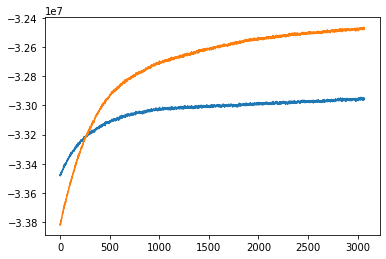

In [17]:
plt.plot(log_prob[500:])

In [25]:
import imageio, cv2
from scipy import io

def project(xys, calibration):
    shape = xys.shape
    xyz = xys.reshape(-1,3) @ calibration['r'] + calibration['t']
    distCoeffs = np.hstack([calibration['RDistort'][0],calibration['TDistort'][0]])
    uv = cv2.projectPoints(xyz,np.zeros(3),np.zeros(3),calibration['K'].T, distCoeffs)[0].squeeze()
    return uv.reshape(*shape[:-1],2)

import joblib
j_names = joblib.load('../UGNE/skeletal_params.p')['j_names']

data_dir = '../UGNE/2021_07_03_M2_M3/'
readers = [imageio.get_reader(data_dir+'/videos/Camera{}/0.mp4'.format(cam)) for cam in range(1,7)]
calibs = [io.loadmat(data_dir+'/calibration/hires_cam{}_params.mat'.format(i)) for i in range(1,7)]

xyzs,uvs = [],[]
for f in ['predictLS_xx2_rat1','predictLS_xx2_rat2']:
    dannce = io.loadmat(data_dir+'/DANNCE/'+f+'/save_data_AVG.mat')
    xyz = np.moveaxis(dannce['pred'],1,2)[:,joint_order,:]
    uvs.append([project(xyz,calibration) for calibration in calibs])
    xyzs.append(xyz)

In [ ]:
x1 = kps.kinematics_models[0].samples['positions']
x2 = kps.kinematics_models[1].samples['positions']

In [101]:
def _log_likelihood(self, obs):
    pred = jax.vmap(gimbal.mcmc.project, in_axes=(0,None), out_axes=-3)(
        self.params['camera_matrices'], self.samples['positions'])
    err = pred-self.reshape_obs(obs)
    inlier_lp = gaussian_log_prob(err, self.params['obs_inlier_location'], self.params['obs_inlier_precision'])
    outlier_lp = gaussian_log_prob(err, self.params['obs_outlier_location'], self.params['obs_outlier_precision'])
    prior = jnp.stack([1-params['obs_outlier_probability'],params['obs_outlier_probability']])
    lp = jax.nn.logsumexp(jnp.stack([inlier_lp,outlier_lp]), b=prior[:,na], axis=0)
    return jnp.swapaxes(lp, -1, -2)

In [111]:
50**2/100/2

12.5

In [108]:
800**2/200000

3.2

In [109]:
np.log(200000)

12.206072645530172

In [110]:
np.log(200)

5.298317366548036

In [103]:
cam = 0
for model_ix in range(2):
    for obs_ix in range(2):
        model = models[model_ix]
        pred = jax.vmap(gimbal.mcmc.project, in_axes=(0,None), out_axes=-3)(
            model.params['camera_matrices'], model.samples['positions'])
        err = pred-model.reshape_obs(observations[obs_ix])
        inlier_lp = gaussian_log_prob(err, model.params['obs_inlier_location'], model.params['obs_inlier_precision'])
        outlier_lp = gaussian_log_prob(err, model.params['obs_outlier_location'], model.params['obs_outlier_precision'])
        prior = jnp.stack([1-params['obs_outlier_probability'],params['obs_outlier_probability']])
        lp = jax.nn.logsumexp(jnp.stack([inlier_lp,outlier_lp]), b=prior[:,na], axis=0)
        print('model',model_ix,' obs',obs_ix)
        print('\toverall lp',lp[ii,cam,joint])
        print('\tinlier  lp',inlier_lp[ii,cam,joint])
        print('\toutlier lp',outlier_lp[ii,cam,joint])
        print('\t       err',err[ii,cam,joint])


model 0  obs 0
	overall lp -15.718123
	inlier  lp -2936.357
	outlier lp -14.1086855
	       err [ 745.20984 -176.10413]
model 0  obs 1
	overall lp -15.421
	inlier  lp -20.398468
	outlier lp -13.81709
	       err [-48.79016   27.895874]
model 1  obs 0
	overall lp -15.428848
	inlier  lp -43.598705
	outlier lp -13.81941
	       err [ 82.871704 -30.512085]
model 1  obs 1
	overall lp -15.692849
	inlier  lp -2683.6128
	outlier lp -14.083411
	       err [-711.1283   173.48792]


In [58]:
(jnp.stack(assign_lls)+self.identity).shape

(2, 2, 2, 4000, 23, 6)

In [59]:
self.observations.shape

(2, 4000, 23, 6, 2)

In [60]:
self.outlier_probs.shape

(2, 4000, 23, 6)

In [ ]:
self = kps
assign_lls = [jax.vmap(model.log_likelihood)(self.observations, self.outlier_probs) for model in self.kinematics_models]
self.assignments = self.forward_backward_assignments(jnp.stack(assign_lls)+self.identity)


In [56]:
# get subtree potentials by message passing up the tree
N, T, K, C, permutations = *self.observations.shape[:-1], self.permutations
clique_marg = self.normalize((jnp.stack(assign_lls)[permutations] * jnp.eye(N).reshape(1,N,N,1,1,1)).sum((1,2)))
subtree_marg = jax.lax.scan(self.tree_pass_backward, clique_marg, self.top_order[::-1])[0]     

# sample full posterior sample by sampling down the tree
self.key, newkey = jax.random.split(self.key)
pass_forward = partial(self.tree_samp_forward, subtree_marg)
samples = jax.lax.scan(pass_forward, (newkey, jnp.zeros((T,K,C),dtype=int)), self.top_order)[0][1]


NameError: name 'assign_lls' is not defined

In [131]:
k = 6
cond_k = jnp.take_along_axis(self.clique_affinity_row_norm[:,:,:,k], samples[:,self.parents[k]][na,na], axis=1)[:,0]

In [133]:
cond_k[:,ii,0]

DeviceArray([-1.4540265 , -0.26608723], dtype=float32)

In [128]:
parents[6]

DeviceArray(5, dtype=int32)

In [124]:
clique_marg[:,ii,6,0]

DeviceArray([-1.0125618, -0.451437 ], dtype=float32)

In [125]:
subtree_marg[:,ii,6,0]

DeviceArray([-1.0125618, -0.451437 ], dtype=float32)

In [141]:
print(affinity[:,:,ii,6,0])
plt.imshow(affinity[:,:,ii,6,0])
plt.colorbar()

DeviceArray([[-0.00678062, -4.9971    ],
             [-1.2765069 , -0.32713032]], dtype=float32)

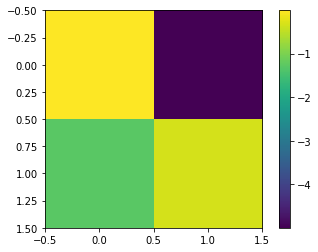

12671


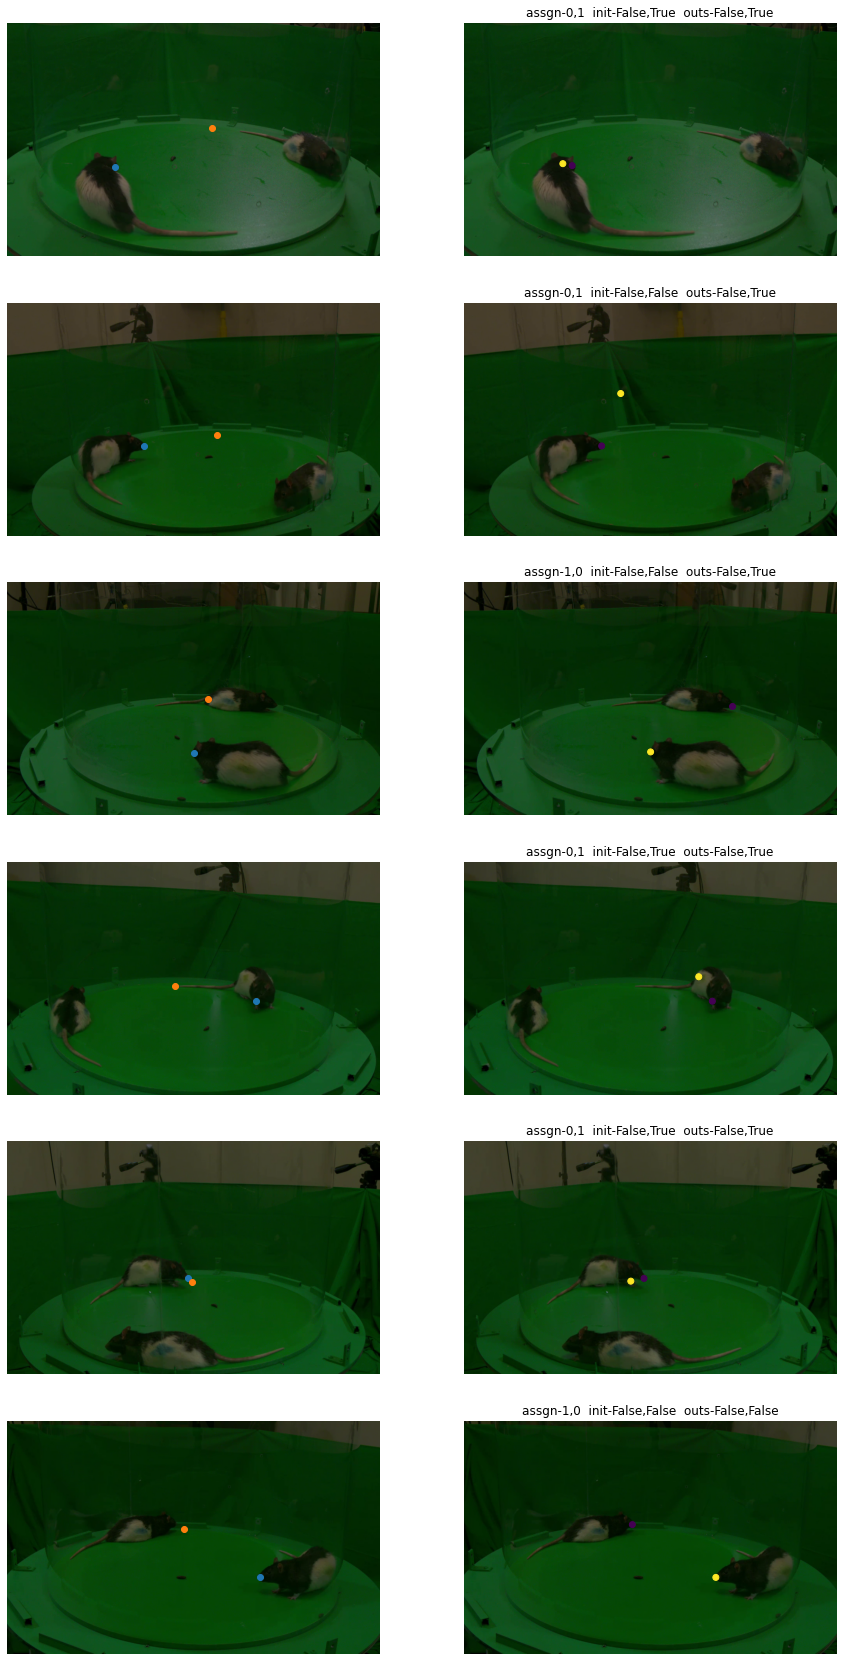

In [31]:
#ii = np.random.randint(observations.shape[1])
ii = 12671
joint = 1
print(ii)

ims = [readers[cam].get_data(ii+70000) for cam in range(6)]
fig,axs = plt.subplots(6,2)
for cam in range(6):
    axs[cam,0].imshow(ims[cam])
    axs[cam,1].imshow(ims[cam])
    axs[cam,0].scatter(*project(np.array(models[0].samples['positions'][ii]), calibs[cam]).T[:,joint])
    axs[cam,0].scatter(*project(np.array(models[1].samples['positions'][ii]), calibs[cam]).T[:,joint])
    axs[cam,1].scatter(*observations[:,ii,joint,cam,:].T, c=range(2))
    axs[cam,1].set_title('assgn-{},{}  init-{},{}  outs-{},{}'.format(
        *kps.assignments[:,ii,joint,cam],
        *initial_outliers[:,ii,joint,cam],
        models[0].samples['outliers'][ii,cam,joint],
        models[1].samples['outliers'][ii,cam,joint]
    ))
    #ff = ~initial_outliers[:,ii,:,cam].flatten()
    #axs[cam,1].scatter(*observations[:,ii,:,cam].reshape(-1,2).T[:,ff], c=kps.assignments[:,ii,:,cam].flatten()[ff])
for ax in axs.flat: ax.axis('off')
fig.set_size_inches((15,30))

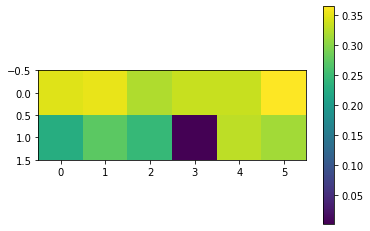

In [90]:
plt.imshow(score[:,296,6,:])
plt.colorbar()

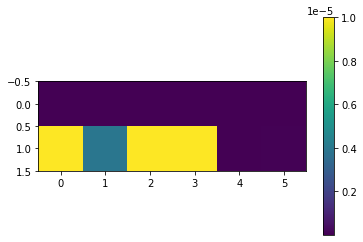

In [95]:
plt.imshow(outlier_probs[:,296,6,:], vmax=0.00001)
plt.colorbar()

In [82]:
score[0,3065,1,5]

DeviceArray(0.06053249, dtype=float32)

In [38]:
pnew = models[0].samples['positions'].at[ii,joint,0].set(50)

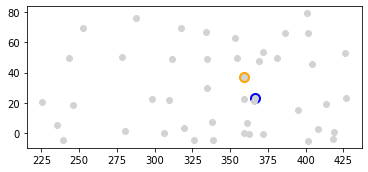

In [31]:
plt.scatter(*models[0].samples['positions'][ii,joint,1:],s=100,c='b')
#plt.scatter(*pnew[ii,joint,:2],s=100, c='b')
plt.scatter(*models[1].samples['positions'][ii,joint,1:],s=100, c='orange')
plt.scatter(*models[0].samples['positions'][ii,:,1:].T, c='lightgray')
plt.scatter(*models[1].samples['positions'][ii,:,1:].T, c='lightgray')
plt.gca().set_aspect('equal')

In [25]:
plt.plot([s['positions'][ii,joint,0] for s in samples1])

NameError: name 'ii' is not defined

In [44]:
from gimbal.util import (opencv_triangulate,
                  xyz_to_uv, uv_to_xyz, signed_angular_difference,
                  Rxy_mat, cartesian_to_polar,
                  children_of, tree_graph_laplacian, hvmfg_natural_parameter,)

def log_joint_probability(params, observations,
                          outliers, positions, directions,
                          heading, pose_state, transition_matrix):
    """Compute the log joint probabiltiy of sampled values under the
    prior parameters. 

    Parameters
    ----------
        params: dict
        observations: ndarray, shape (N, C, K, D_obs).
        outliers: ndarray, shape (N, C, K).
        positions: ndarray, shape (N, K, D).
        directions: ndarray, shape (N, K, D).
        heading: ndarray, shape (N,).
        pose_state: ndarray, shape (N,).
        transition_matrix: ndarray, shape (S,S).
    """

    C, S = observations.shape[1], transition_matrix.shape[0]

    Z_prior = tfd.Bernoulli(probs=params['obs_outlier_probability'])
    
    # Y_ins = tfd.MultivariateNormalFullCovariance(params['obs_inlier_location'], params['obs_inlier_covariance'])  # batch shape (num_cams, num_joints), event_shape (dim_obs)
    # Y_outs = tfd.MultivariateNormalFullCovariance(params['obs_outlier_location'], params['obs_outlier_covariance'])
    Y_ins = [tfd.MultivariateNormalFullCovariance(
                        params['obs_inlier_location'][c],
                        params['obs_inlier_covariance'][c]) \
            for c in range(C)]
    Y_outs = [tfd.MultivariateNormalFullCovariance(
                        params['obs_outlier_location'][c],
                        params['obs_outlier_covariance'][c]) \
            for c in range(C)]
    X_t0 = tfd.MultivariateNormalFullCovariance(
                params['pos_location_0'].ravel(),
                params['pos_covariance_0'])
    # U_given_S = VMF(params['pstate']['mus'], params['pstate']['kappas'])  # batch shape (num_states, num_joints), event_shape (dim)

    # =================================================

    def log_likelihood(xt, yts, zts, params):
        """ Compute log likelihood of observations for a single time step.

        log p(y[t] | x[t], z[t]) = 
                z[t] log N(y[t] | proj(x[t]; P), omega_in)
                + (1-z[t]) log N(y[t] | proj(x[t]; P), omega_out)
        """

        # Does not work :( ... Error message
        # Shapes must be 1D sequences of concrete values of integer type, got [Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/2)>].
        # If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
        # obs_err = np.stack([yts[c] - project(xt, params["Ps"][c]) \
        #                     for c in range(yts.shape[0])], axis=0)
        # lp = (1-zts) * Y_ins.log_prob(obs_err) + zts * Y_outs.log_prob(obs_err)

        lp = 0
        # for c in range(yts.shape[0]):
        for c in range(C):
            obs_err = yts[c] - gimbal.util.project(params["camera_matrices"][c], xt)
            lp += (1-zts[c]) * Y_ins[c].log_prob(obs_err)
            lp += zts[c] * Y_outs[c].log_prob(obs_err)
            # Y_in = tfd.MultivariateNormalFullCovariance(params['obs_inlier_location'][c], params['obs_inlier_covariance'][c])
            # Y_out = tfd.MultivariateNormalFullCovariance(params['obs_outlier_location'][c], params['obs_outlier_covariance'][c])
            # lp += (1-zts[c]) * Y_in.log_prob(obs_err)
            # lp += zts[c] * Y_out.log_prob(obs_err)
        return jnp.sum(lp)
    
    def log_pos_given_dir(xt, ut, params):
        """ Compute log likelihood of positions given directions for a
        single time step.

        log p(x[t] | u[t]) = prod_j N(x[t,parj] + r[j] u[t,j], sigma^2 I)
        """
        ht = hvmfg_natural_parameter(
                    params['children'], params['pos_radius'],
                    params['pos_radial_variance'],
                    ut)
        Xt_given_Ut = tfd.MultivariateNormalFullCovariance(
                            params['pos_radial_covariance'] @ ht.ravel(),
                            params['pos_radial_covariance'])
        return Xt_given_Ut.log_prob(xt.ravel())
    
    def log_pos_dynamics(xtp1, xt, params):
        """ Compute log p(x[t+1] | x[t]) = log N(x[t], sigma^2 I) """
        Xtp1_given_Xt = tfd.MultivariateNormalFullCovariance(
                                xt.ravel(), params['pos_dt_covariance'])
        return Xtp1_given_Xt.log_prob(xtp1.ravel())
    
    def log_dir_given_state(ut, ht, st, params):
        """ Compute log p(R(-h[t]) u[t] | h[t], s[t]) = log vMF(nu_s[t], kappa_s[t]) """
        canon_ut = ut @ Rxy_mat(-ht).T
        u_given_st = tfd.VonMisesFisher(
                        params['state_directions'][st],
                        params['state_concentrations'][st])
        return jnp.sum(u_given_st.log_prob(canon_ut))

    # =================================================
    
    # p(y | x, z)
    lp1 = jax.vmap(log_likelihood, in_axes=(0,0,0,None))(positions, observations, outliers, params)

    # p(z; rho)
    lp2 = Z_prior.log_prob(outliers)

    # p(x | u)
    lp3 = jax.vmap(log_pos_given_dir, in_axes=(0,0,None))(positions, directions, params)
    
    '''
    # p(x[t] | x[t-1])
    lp += jnp.sum(vmap(log_pos_dynamics, in_axes=(0,0,None))
                      (positions[1:], positions[:-1], params))
    lp += X_t0.log_prob(positions[0].ravel())
    '''

    # p(u | s)
    # canon_u = jnp.einsum('tmn, tjn-> tjm', R_mat(-h), u)
    # lp = jnp.sum(U_given_S[s].log_prob(canon_u))
    lp4 = jax.vmap(log_dir_given_state, in_axes=(0,0,0,None))(directions, heading, pose_state, params)

    # p(h) = VonMises(0, 0), so lp = max entropy over circle, which is constant

    # p(s[0]) + sum p(s[t+1] | s[t])
    lp5 = jnp.log(transition_matrix[pose_state[1:], pose_state[:-1]])
    lp6 = jnp.log(params['state_probability'])

    return lp1,lp3,lp4


obs = models[0].reshape_obs(kps.split(observations,kps.assignments)[0])
positions = models[0].samples['positions']
pnew = models[0].samples['positions'].at[ii,joint,0].set(50)
lps = log_joint_probability(
    models[0].params,
    obs,
    models[0].samples['outliers'],
    positions,
    models[0].samples['directions'],
    models[0].samples['heading'],
    models[0].samples['pose_state'],
    models[0].samples['transition_matrix'])

lpsnew = log_joint_probability(
    models[0].params,
    obs,
    models[0].samples['outliers'],
    pnew,
    models[0].samples['directions'],
    models[0].samples['heading'],
    models[0].samples['pose_state'],
    models[0].samples['transition_matrix'])


In [45]:
for lp in lps: print(lp[ii])

-1564.7075
-213.76227
-46.950333


In [46]:
for lp in lpsnew: print(lp[ii])

-1564.7507
-236.35484
-46.950333


In [ ]:
# p(y | x, z)
# p(x | u)
# p(u | s)

In [31]:
lps[1].shape

(300, 6, 23)

In [ ]:
split_obs

In [ ]:
sample_outliers(seeds[1], params, observations, samples)

In [26]:
colors = [(126, 30, 156), (254, 179, 8), (254, 179, 8), 
          (254, 179, 8), (126, 30, 156), (126, 30, 156), 
          (126, 30, 156), (229, 0, 0), (229, 0, 0), 
          (229, 0, 0), (229, 0, 0), (3, 67, 223), 
          (3, 67, 223), (3, 67, 223), (3, 67, 223), 
          (154, 14, 234), (154, 14, 234), (154, 14, 234), 
          (154, 14, 234), (21, 176, 26), (21, 176, 26), 
          (21, 176, 26), (21, 176, 26)]

links = [(i,j) for i,j in enumerate(parents) if i != j]
gimbal_positions = [np.array(models[0].samples['positions']),np.array(models[1].samples['positions'])]
dannce_positions = [xyz[70000:] for xyz in xyzs]

In [27]:
cameras = [0,1]
writer = imageio.get_writer('gimbal_vs_dannce.mp4', pixelformat='yuv420p', fps=30, quality=8)
for frame_ix in tqdm.trange(len(observations[0])):
    rows = []
    for cam in cameras:
        row = []
        base_im = readers[cam].get_data(frame_ix+70000)[::2,::2]
        for coords,name in zip([gimbal_positions, dannce_positions], ('GIMBAL','DANNCE')):
            im = base_im.copy()
            for rat in range(2):
                uvs = (project(coords[rat][frame_ix], calibs[cam])/2).astype(int)
                uvs = [(uv[0],uv[1]) for uv in uvs]
                for i,j in links: im = cv2.line(im, uvs[i], uvs[j], colors[i], 2, cv2.LINE_AA)
                for uv,c in zip(uvs,colors): 
                    im = cv2.circle(im, uv, 5, c, -1, cv2.LINE_AA)
                    im = cv2.circle(im, uv, 5, (0,0,0), 1, cv2.LINE_AA)
            im = cv2.putText(im, name, (250,60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
            row.append(im)
            
        rows.append(np.hstack(row))
    full_im = np.vstack(rows)
    cv2.putText(full_im, repr(frame_ix), (10,60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
    writer.append_data(full_im)
writer.close()

  0%|          | 0/19001 [00:00<?, ?it/s]

In [28]:
writer.close()

In [86]:
gimbal_positions_mean = [np.mean([s['positions'] for s in samples1[-10:]],axis=0),
                         np.mean([s['positions'] for s in samples2[-10:]],axis=0)]


In [87]:
cameras = [0,1]
writer = imageio.get_writer('gimbal_vs_dannce_mean.mp4', pixelformat='yuv420p', fps=30, quality=8)
for frame_ix in tqdm.trange(4000):
    rows = []
    for cam in cameras:
        row = []
        base_im = readers[cam].get_data(frame_ix+70000)[::2,::2]
        for coords,name in zip([gimbal_positions_mean, dannce_positions], ('GIMBAL','DANNCE')):
            im = base_im.copy()
            for rat in range(2):
                uvs = (project(coords[rat][frame_ix], calibs[cam])/2).astype(int)
                uvs = [(uv[0],uv[1]) for uv in uvs]
                for i,j in links: im = cv2.line(im, uvs[i], uvs[j], colors[i], 2, cv2.LINE_AA)
                for uv,c in zip(uvs,colors): 
                    im = cv2.circle(im, uv, 5, c, -1, cv2.LINE_AA)
                    im = cv2.circle(im, uv, 5, (0,0,0), 1, cv2.LINE_AA)
            im = cv2.putText(im, name, (250,60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
            row.append(im)
            
        rows.append(np.hstack(row))
    full_im = np.vstack(rows)
    cv2.putText(full_im, repr(frame_ix), (10,60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
    writer.append_data(full_im)
writer.close()

  0%|          | 0/4000 [00:00<?, ?it/s]

In [14]:
writer.close()

In [59]:
gimbal_positions[0].shape

(5000, 23, 3)

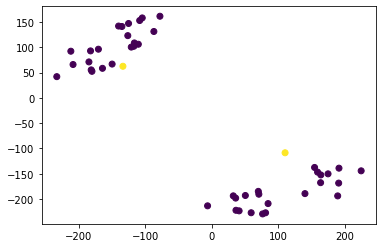

In [63]:
plt.scatter(*gimbal_positions[0][ii,:,:2].T, c=np.arange(23)==18)
plt.scatter(*gimbal_positions[1][ii,:,:2].T, c=np.arange(23)==18)

In [68]:
position_hist = []
outlier_hist = []
assign_hist = []

frame = 149
pbar = tqdm.trange(30)
for itr in pbar:
    split_obs = kps.split(kps.observations,kps.assignments)
    for itr2 in range(30):
        for obs,model in zip(split_obs,kps.kinematics_models): model.step(obs)
        assign_hist.append(kps.assignments[:,ii,:,:])
        outlier_hist.append([m.samples['outliers'][ii] for m in kps.kinematics_models])
        position_hist.append([m.samples['positions'][ii] for m in kps.kinematics_models])
    assign_lls = [jax.vmap(model.log_likelihood)(kps.observations) for model in kps.kinematics_models]
    kps.assignments = kps.forward_backward_assignments(jnp.stack(assign_lls)+kps.identity)

  0%|          | 0/30 [00:00<?, ?it/s]

In [69]:
position_hist = np.array(position_hist)
outlier_hist = np.array(outlier_hist)
assign_hist = np.array(assign_hist)
ims = [readers[cam].get_data(frame+70000)[::2,::2] for cam in range(6)]

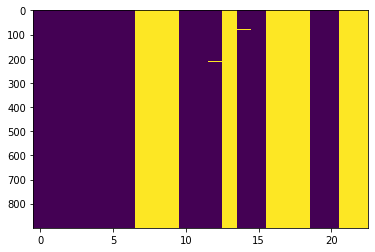

In [75]:
plt.imshow(outlier_hist[:,1,1,:], aspect='auto', interpolation='nearest')

In [71]:
joint = 18
writer = imageio.get_writer('fitting_progress_joint{}.mp4'.format(joint), pixelformat='yuv420p', fps=30, quality=8)
for i in tqdm.trange(len(position_hist)):
    cam_ims = []
    for cam in range(6):
        im = ims[cam].copy()
        proj = (project(position_hist[i,:,joint], calibs[cam])/2).astype(int)
        colors = [(255,0,0),(0,0,255)]
        cv2.circle(im, (proj[0,0],proj[0,1]), 10, colors[0], -1, cv2.LINE_AA)
        cv2.circle(im, (proj[1,0],proj[1,1]), 10, colors[1], -1, cv2.LINE_AA)
        
        assign_colors = [colors[ii] for ii in  assign_hist[i,:,joint,cam]]
        obs1 = np.array(observations[0,frame,joint,cam,:]/2, dtype=int)
        obs2 = np.array(observations[1,frame,joint,cam,:]/2, dtype=int)
        cv2.circle(im, (obs1[0],obs1[1]), 9, assign_colors[0], -1, cv2.LINE_AA)
        cv2.circle(im, (obs2[0],obs2[1]), 9, assign_colors[1], -1, cv2.LINE_AA)
        if outlier_hist[i,0,cam,joint]:
            cv2.circle(im, (obs1[0],obs1[1]), 15, (0,0,0), 2, cv2.LINE_AA)
        if outlier_hist[i,1,cam,joint]:
            cv2.circle(im, (obs2[0],obs2[1]), 15, (0,0,0), 2, cv2.LINE_AA)
        cam_ims.append(im)
    full_im = np.vstack([np.hstack(cam_ims[:3]),np.hstack(cam_ims[3:])])
    cv2.putText(full_im, repr(i), (10,60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
    writer.append_data(full_im)
writer.close()

  0%|          | 0/900 [00:00<?, ?it/s]

In [65]:
writer.close()

In [70]:
(outlier_hist[:,1,:,:]).mean()

0.6555555555555556

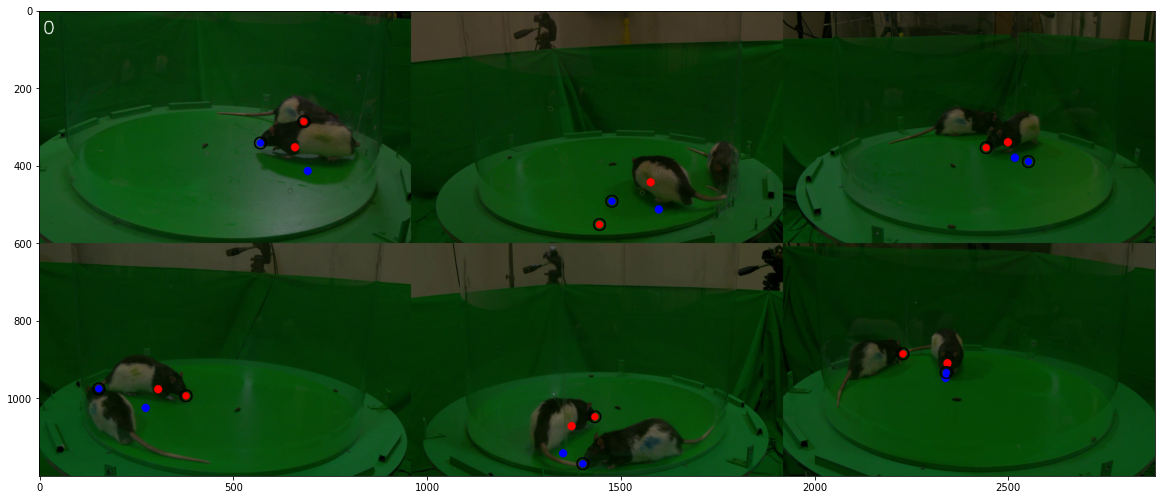

In [62]:
plt.imshow(full_im)
plt.gcf().set_size_inches((20,10))

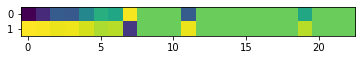

In [62]:
plt.imshow(identity[1,:,ii,:,camera])


In [67]:
coms, score, affinity, observations = load_keypoint_detections('../UGNE/keypoint_detections/', truncate=2000)
identity = -1/2 * ((observations[:,na] - coms[na,:,:,na,:,:])**2).sum(-1)/200**2

initial_outliers = score < .1
parent_outliers = initial_outliers[:,:,parents,:]
observations = jnp.where(initial_outliers[...,na], jnp.nan, observations)
identity = jnp.where(initial_outliers[:,na], 0, identity)
affinity = jnp.where(initial_outliers[:,na], 0, affinity)
affinity = jnp.where(parent_outliers[na,:],  0, affinity)
#identity = identity - jax.nn.logsumexp(identity,axis=1, keepdims=True)
#affinity = affinity - jax.nn.logsumexp(affinity,axis=1, keepdims=True)


Truncating all detections to 2000 frames


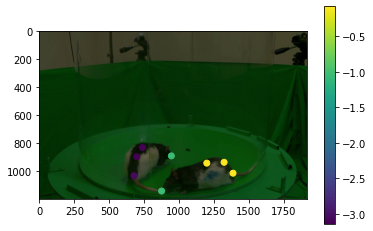

In [20]:
camera = 4
plt.imshow(ims[camera])
plt.scatter(observations[0,ii,id_joints,camera,0],
            observations[0,ii,id_joints,camera,1], 
            c=identity[0,0,ii,id_joints,camera])
plt.scatter(observations[1,ii,id_joints,camera,0],
            observations[1,ii,id_joints,camera,1], 
            c=identity[1,0,ii,id_joints,camera])
plt.colorbar()

In [56]:
observations[0,ii,:,camera,0]

DeviceArray([ 946.,  868.,  920., 1076.,  738., 1324., 1388., 1098.,
             1112., 1084., 1036.,  868.,  870.,  874.,  904., 1332.,
              658., 1324., 1234.,  760.,  790.,  756.,  784.],            dtype=float32)

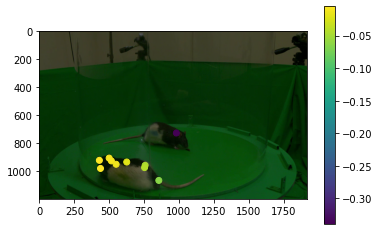

In [35]:
camera = 4
plt.imshow(ims[camera])
plt.scatter(observations[1,ii,:,camera,0],
            observations[1,ii,:,camera,1], 
            c=identity[1,1,ii,:,camera])
plt.colorbar()

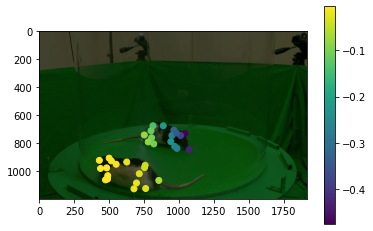

In [36]:
camera = 4
plt.imshow(ims[camera])
plt.scatter(observations[:,ii,:,camera,0].flatten(),
            observations[:,ii,:,camera,1].flatten(), 
            c=identity[:,1,ii,:,camera].flatten())
plt.colorbar()

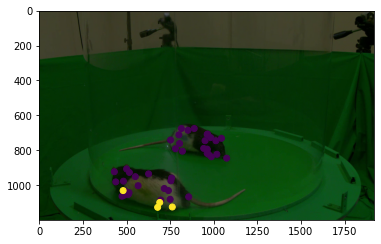

In [100]:
camera = 4
plt.imshow(ims[camera])
plt.scatter(observations[:,ii,:,camera,0].flatten(),
            observations[:,ii,:,camera,1].flatten(), 
            c=np.in1d((jnp.ones((2,1))*jnp.arange(23)).flatten(),[17,18]))


In [33]:
ims = [readers[cam].get_data(frame+70000) for cam in range(6)]

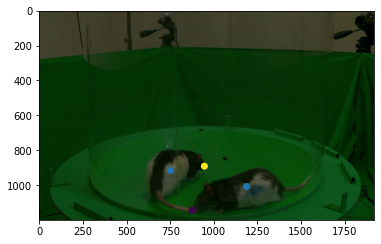

In [34]:
ii = 700
camera= 4
plt.imshow(ims[camera])
plt.scatter(observations[:,ii,0,camera,0],
            observations[:,ii,0,camera,1], 
            c=identity[:,0,ii,0,camera])
plt.scatter(coms[:,ii,camera,0],coms[:,ii,camera,1])

In [43]:
coms.shape

(2, 2000, 6, 2)

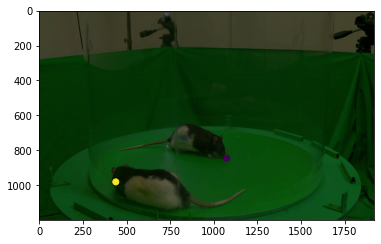

In [39]:
plt.imshow(ims[camera])
plt.scatter(observations[:,ii,0,camera,0],
            observations[:,ii,0,camera,1], 
            c=identity[:,1,ii,0,camera])
plt.colorbar

In [40]:
models[0].samples['outliers'].shape

(2000, 6, 23)

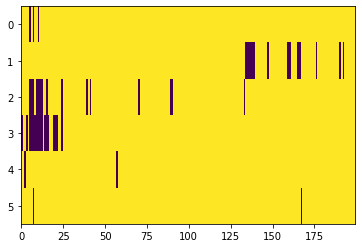

In [44]:
plt.imshow(models[0].samples['outliers'][600:800,:,0].T, aspect='auto', interpolation='nearest')

In [60]:
self = kps
split_obs = self.split(self.observations,self.assignments)
for obs,model in zip(split_obs,self.kinematics_models): model.step(obs)
assign_lls = [jax.jit(jax.vmap(model.log_likelihood))(self.observations) for model in self.kinematics_models]
assign_lls = jnp.stack(assign_lls)


In [62]:
params.keys()

dict_keys(['obs_outlier_probability', 'obs_outlier_location', 'obs_outlier_variance', 'obs_inlier_location', 'obs_inlier_variance', 'camera_matrices', 'pos_radius', 'pos_radial_variance', 'parents', 'pos_dt_variance', 'state_probability', 'state_directions', 'state_concentrations', 'crf_keypoints', 'crf_abscissa', 'crf_normal', 'crf_axes', 'state_transition_count', 'obs_outlier_covariance', 'obs_inlier_covariance'])

In [ ]:
self = kps
split_obs = self.split(self.observations,self.assignments)
for obs,model in zip(split_obs,self.kinematics_models): model.step(obs)
assign_lls = [jax.jit(jax.vmap(model.log_likelihood))(self.observations) for model in self.kinematics_models]
assign_lls = jnp.stack(assign_lls)

assign_lls += self.identity
N, T, K, C, permutations = *self.observations.shape[:-1], self.permutations
clique_marg = self.normalize((assign_lls[permutations] * jnp.eye(N).reshape(1,N,N,1,1,1)).sum((1,2)))
subtree_marg = jax.lax.scan(self.tree_pass_backward, clique_marg, self.top_order[::-1])[0]     


In [ ]:
identity = -1/2 * ((observations[:,na] - coms[na,:,:,na,:,:])**2).sum(-1)/200**2
identity = identity - jax.nn.logsumexp(identity,axis=1, keepdims=True)
